In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
df=pd.read_csv("train.csv")

In [3]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
for col in df.columns:
    print(f"{col}\t{(df[col].isnull().sum()/1460)*100}")

Id	0.0
MSSubClass	0.0
MSZoning	0.0
LotFrontage	17.73972602739726
LotArea	0.0
Street	0.0
Alley	93.76712328767123
LotShape	0.0
LandContour	0.0
Utilities	0.0
LotConfig	0.0
LandSlope	0.0
Neighborhood	0.0
Condition1	0.0
Condition2	0.0
BldgType	0.0
HouseStyle	0.0
OverallQual	0.0
OverallCond	0.0
YearBuilt	0.0
YearRemodAdd	0.0
RoofStyle	0.0
RoofMatl	0.0
Exterior1st	0.0
Exterior2nd	0.0
MasVnrType	59.726027397260275
MasVnrArea	0.547945205479452
ExterQual	0.0
ExterCond	0.0
Foundation	0.0
BsmtQual	2.5342465753424657
BsmtCond	2.5342465753424657
BsmtExposure	2.6027397260273974
BsmtFinType1	2.5342465753424657
BsmtFinSF1	0.0
BsmtFinType2	2.6027397260273974
BsmtFinSF2	0.0
BsmtUnfSF	0.0
TotalBsmtSF	0.0
Heating	0.0
HeatingQC	0.0
CentralAir	0.0
Electrical	0.0684931506849315
1stFlrSF	0.0
2ndFlrSF	0.0
LowQualFinSF	0.0
GrLivArea	0.0
BsmtFullBath	0.0
BsmtHalfBath	0.0
FullBath	0.0
HalfBath	0.0
BedroomAbvGr	0.0
KitchenAbvGr	0.0
KitchenQual	0.0
TotRmsAbvGrd	0.0
Functional	0.0
Fireplaces	0.0
FireplaceQu	47.260273

In [5]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# --- 1. Handle Numerical Missing Values ---
# For LotFrontage (17% missing)
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())

# For other numeric columns (MasVnrArea, GarageYrBlt), fill with 0
# (Because usually NaN means "No Garage" or "No Masonry")
df[num_cols] =df[num_cols].fillna(0)

# --- 2. Handle Categorical Missing Values ---
# For columns like PoolQC, Fence, FireplaceQu, GarageType, etc.
# We fill NaN with "None" (a new category)
df[cat_cols] = df[cat_cols].fillna("None")

# Check if any missing values remain
print("Missing values in data:", df.isnull().sum().sum())

Missing values in data: 0


In [6]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


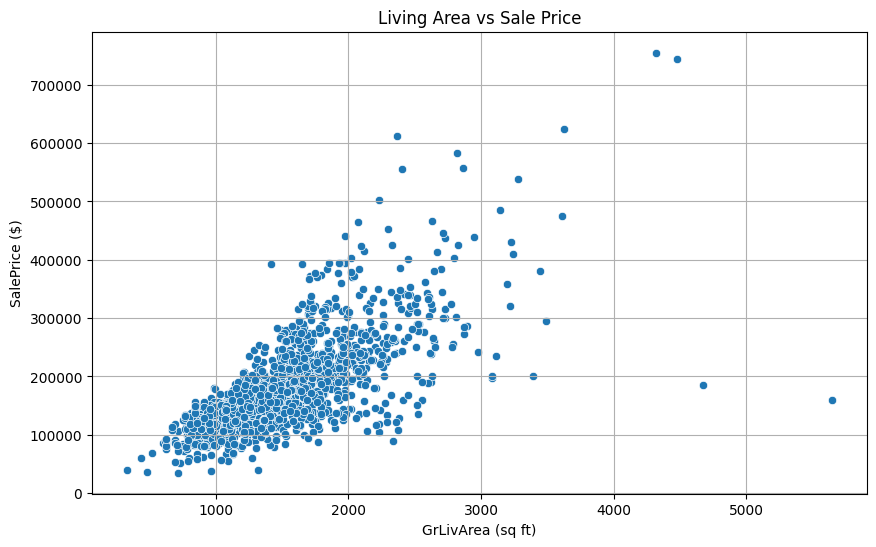

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['GrLivArea'],y=df['SalePrice'])
plt.title("Living Area vs Sale Price")
plt.xlabel("GrLivArea (sq ft)")
plt.ylabel("SalePrice ($)")
plt.grid(True)
plt.show()

In [8]:
# 1. The copy for Linear Regression, SVM, Lasso, Ridge
# We will: Remove outliers, Scale data, Log-transform the target
df_linear = df.copy()

# 2. The copy for Random Forest, XGBoost, Decision Trees
# We will: Keep outliers (mostly), No scaling needed
df_trees = df.copy()

In [9]:
# 1. Calculate Skewness
numeric_feats = df_linear.select_dtypes(include=['int64', 'float64']).columns
skewed_feats = df_linear[numeric_feats].apply(lambda x: x.skew()).sort_values(ascending=False)

# 2. Filter features with skew > 0.75
skewness_df = pd.DataFrame({'Skew': skewed_feats})
skewed_features = skewness_df[skewness_df['Skew'] > 0.75].index

# --- CRITICAL FIX: DROP SALE PRICE FROM THIS LIST ---
if 'SalePrice' in skewed_features:
    skewed_features = skewed_features.drop('SalePrice')

# 3. Apply transformation ONLY to features (not target)
df_linear[skewed_features] = np.log1p(df_linear[skewed_features])

print("Skewness fixed for features. SalePrice untouched.")

Skewness fixed for features. SalePrice untouched.


In [10]:
# Remove the documented "Bad Data" from the main source
# (Area > 4000 and Price < 300,000)
bad_data_index = df[(df['GrLivArea'] > 4000) & (df['SalePrice'] < 300000)].index

df_linear = df_linear.drop(bad_data_index)
df_trees = df_trees.drop(bad_data_index)

print(f"Removed {len(bad_data_index)} Bad Data points from both datasets.")

Removed 2 Bad Data points from both datasets.


In [11]:
import numpy as np

# 1. Get list of skewed features (Skew > 0.75)
skewed_features = skewed_feats[skewed_feats > 0.75].index

# 2. Apply Log(1 + x) Transformation
# We use log1p because log(0) is impossible (-infinity). log1p adds 1 automatically.
df_linear[skewed_features] = np.log1p(df_linear[skewed_features])

print(f"Transformed {len(skewed_features)} skewed features in df_linear.")

# Check the new skewness of LotArea (Used to be 12.2)
print(f"New Skewness of LotArea: {df_linear['LotArea'].skew()}")

Transformed 22 skewed features in df_linear.
New Skewness of LotArea: -0.18127758596851626


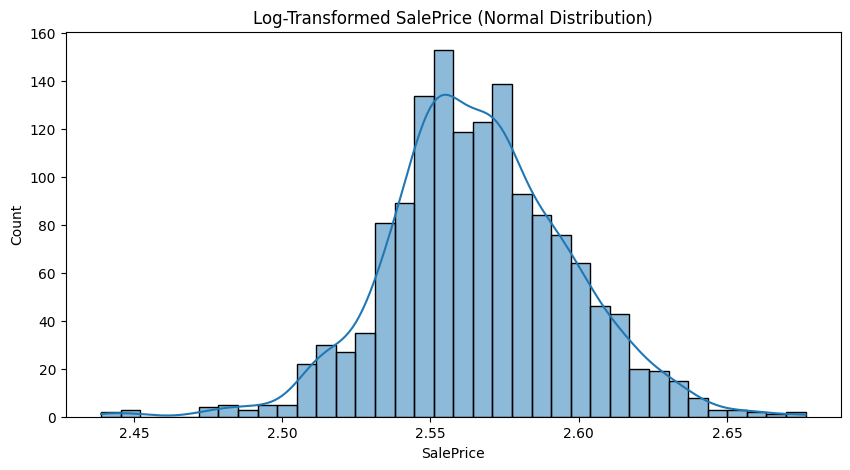

In [12]:
# Transform the Target
df_linear['SalePrice'] = np.log1p(df_linear['SalePrice'])

# Visualize the improvement
plt.figure(figsize=(10,5))
sns.histplot(df_linear['SalePrice'], kde=True)
plt.title("Log-Transformed SalePrice (Normal Distribution)")
plt.show()

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# 1. Define Features (X) and Target (y) from the LINEAR copy
X_lin = df_linear.drop('SalePrice', axis=1)
y_lin = df_linear['SalePrice'] # Remember: This is already Log-Transformed!

# 2. Split Train/Test
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(X_lin, y_lin, test_size=0.2, random_state=42)

# 3. Define Column Groups
# Numeric cols: Fill with Median -> Scale
num_features = X_lin.select_dtypes(include=['int64', 'float64']).columns

# Categorical cols: Fill with "None" -> OneHotEncode
cat_features = X_lin.select_dtypes(include=['object']).columns

# 4. Create Transformers
# Numeric Pipeline
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Fill missing with Median
    ('scaler', StandardScaler())                   # Scale to mean=0, std=1 (Crucial for SVM/Ridge)
])

# Categorical Pipeline
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')), # Fill missing with "None"
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # Convert text to numbers
])

# 5. Combine into a Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

# 6. Apply transformations (This creates the final arrays for training)
X_train_final = preprocessor.fit_transform(X_train_lin)
X_test_final = preprocessor.transform(X_test_lin)

print(f"Final Training Shape: {X_train_final.shape}")

Final Training Shape: (1166, 300)


In [17]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Define models again
models = {
    "Ridge (L2)": Ridge(alpha=20),       
    "Lasso (L1)": Lasso(alpha=0.01),     
    "SVR": SVR(C=5, epsilon=0.05)        
}

print(f"{'MODEL':<20} | {'RMSE (Log Scale)':<20} | {'RMSE (Real Dollars)'}")
print("-" * 65)

for name, model in models.items():
    try:
        # 1. Train
        model.fit(X_train_final, y_train_lin)
        
        # 2. Predict
        y_pred_log = model.predict(X_test_final)
        
        # --- SAFETY CLIP ---
        # Force predictions to stay within reasonable bounds (Log 0 to 15)
        # This prevents the "Infinity" error.
        y_pred_log = np.clip(y_pred_log, 0, 15)
        
        # 3. Calculate Log RMSE
        rmse_log = np.sqrt(mean_squared_error(y_test_lin, y_pred_log))
        
        # 4. Calculate Real RMSE
        y_test_real = np.expm1(y_test_lin)
        y_pred_real = np.expm1(y_pred_log)
        rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
        
        print(f"{name:<20} | {rmse_log:.5f}              | ${rmse_real:,.0f}")
        
    except Exception as e:
        print(f"{name:<20} | FAILED TO CONVERGE ({str(e)})")

MODEL                | RMSE (Log Scale)     | RMSE (Real Dollars)
-----------------------------------------------------------------
Ridge (L2)           | FAILED TO CONVERGE (Input contains infinity or a value too large for dtype('float64').)


C:\Users\lokes\AppData\Roaming\Python\Python313\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\lokes\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.665e+11, tolerance: 7.594e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\lokes\AppData\Roaming\Python\Python313\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)


Lasso (L1)           | FAILED TO CONVERGE (Input contains infinity or a value too large for dtype('float64').)
SVR                  | FAILED TO CONVERGE (Input contains infinity or a value too large for dtype('float64').)


C:\Users\lokes\AppData\Roaming\Python\Python313\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
print("First 5 values of y_train_lin:")
print(y_train_lin.head())
print(f"Max value: {y_train_lin.max()}")

First 5 values of y_train_lin:
254     145000
1066    178000
865     148500
799     175000
380     127000
Name: SalePrice, dtype: int64
Max value: 755000


In [19]:
# --- STEP 1: FRESH RELOAD ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Load Data
df = pd.read_csv('train.csv')

# Drop documented outliers
df = df.drop(df[(df['GrLivArea'] > 4000) & (df['SalePrice'] < 300000)].index)

# Define X and y
# --- THE CRITICAL FIX IS HERE ---
y = np.log1p(df['SalePrice'])  # Force Log Transform immediately
X = df.drop('SalePrice', axis=1)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Double Check (This prints the correct Log values)
print(f"Target Max Value (Should be ~13.5): {y_train.max():.4f}") 

# --- STEP 2: PREPROCESSING ---
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

# Pipeline setup
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

# Transform
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# --- STEP 3: TRAIN & EVALUATE ---
models = {
    "Ridge (L2)": Ridge(alpha=10),       
    "Lasso (L1)": Lasso(alpha=0.0005),     
    "SVR": SVR(C=10, epsilon=0.1)        
}

print(f"\n{'MODEL':<20} | {'RMSE (Log Scale)':<20} | {'RMSE (Real Dollars)'}")
print("-" * 65)

for name, model in models.items():
    model.fit(X_train_processed, y_train)
    y_pred_log = model.predict(X_test_processed)
    
    # Calculate Log Error
    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
    
    # Calculate Real Dollar Error (Invert the Log)
    rmse_real = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_log)))
    
    print(f"{name:<20} | {rmse_log:.5f}              | ${rmse_real:,.0f}")

Target Max Value (Should be ~13.5): 13.5345

MODEL                | RMSE (Log Scale)     | RMSE (Real Dollars)
-----------------------------------------------------------------
Ridge (L2)           | 0.12270              | $19,998
Lasso (L1)           | 0.11698              | $19,397
SVR                  | 0.14064              | $22,546


In [20]:
from xgboost import XGBRegressor

# Initialize XGBoost
# n_estimators=1000: Lots of trees
# learning_rate=0.05: Learn slowly (better accuracy)
# early_stopping_rounds=50: Stop if it stops improving (prevent overfitting)
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, random_state=42)

# XGBoost needs a validation set for early stopping
# We use the test set for this 'watch list'
eval_set = [(X_test_processed, y_test)]

print("Training XGBoost...")
xgb_model.fit(X_train_processed, y_train, 
              eval_set=eval_set, 
              verbose=False) # verbose=False keeps it quiet

# Predict
y_pred_xgb_log = xgb_model.predict(X_test_processed)

# Calculate Scores
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_xgb_log))
rmse_real = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_xgb_log)))

print("\n--- NEW CHALLENGER ---")
print(f"XGBoost RMSE (Log):     {rmse_log:.5f}")
print(f"XGBoost RMSE (Real $):  ${rmse_real:,.0f}")

# Compare with Lasso
print(f"Lasso   RMSE (Log):     0.11698") # Your previous best

Training XGBoost...

--- NEW CHALLENGER ---
XGBoost RMSE (Log):     0.13526
XGBoost RMSE (Real $):  $23,402
Lasso   RMSE (Log):     0.11698


In [21]:
# 1. Get predictions from both models
lasso_pred = models['Lasso (L1)'].predict(X_test_processed)
xgb_pred = xgb_model.predict(X_test_processed)

# 2. Blend them (Weighted Average)
# We give Lasso more weight (0.6) because it performed better
final_pred_log = (0.6 * lasso_pred) + (0.4 * xgb_pred)

# 3. Calculate Score
rmse_log = np.sqrt(mean_squared_error(y_test, final_pred_log))
rmse_real = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(final_pred_log)))

print("--- ENSEMBLE RESULTS ---")
print(f"Lasso Score:    0.11698")
print(f"XGBoost Score:  0.13526")
print(f"Combined Score: {rmse_log:.5f}") # Did we beat 0.11698?
print(f"Real $ Error:   ${rmse_real:,.0f}")

--- ENSEMBLE RESULTS ---
Lasso Score:    0.11698
XGBoost Score:  0.13526
Combined Score: 0.11765
Real $ Error:   $19,266


In [22]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Define Tree Models
tree_models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

print(f"{'MODEL':<20} | {'RMSE (Log Scale)':<20} | {'RMSE (Real Dollars)'}")
print("-" * 65)

for name, model in tree_models.items():
    # 1. Train
    model.fit(X_train_processed, y_train)
    
    # 2. Predict
    y_pred_log = model.predict(X_test_processed)
    
    # 3. Calculate Error
    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
    rmse_real = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_log)))
    
    print(f"{name:<20} | {rmse_log:.5f}              | ${rmse_real:,.0f}")

# Reminder of the score to beat (Lasso)
print("-" * 65)
print(f"{'Lasso (Target)':<20} | 0.11698              | $19,397")

MODEL                | RMSE (Log Scale)     | RMSE (Real Dollars)
-----------------------------------------------------------------
Decision Tree        | 0.21079              | $37,395
Random Forest        | 0.14362              | $24,039
-----------------------------------------------------------------
Lasso (Target)       | 0.11698              | $19,397


In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# 1. Define the grid of hyperparameters to test
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, None],          # How deep the tree can grow
    'min_samples_split': [2, 10, 20, 40, 60],      # Minimum samples required to split a node
    'min_samples_leaf': [1, 5, 10, 20]             # Minimum samples required at a leaf node (Strong pruning)
}

# 2. Initialize Grid Search
# cv=5 means "Cross Validation" (it tests 5 times internally for each combo)
dt_grid = GridSearchCV(DecisionTreeRegressor(random_state=42), 
                       param_grid, 
                       cv=5, 
                       scoring='neg_root_mean_squared_error', # Sklearn maximizes score, so we use negative error
                       n_jobs=-1)

print("Tuning Decision Tree... this might take a minute.")
dt_grid.fit(X_train_processed, y_train)

# 3. Get the Winner
best_tree = dt_grid.best_estimator_
print(f"\nBest Parameters Found: {dt_grid.best_params_}")

# 4. Evaluate on Test Set
y_pred_tuned = best_tree.predict(X_test_processed)

rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
rmse_real = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_tuned)))

print("-" * 50)
print(f"Tuned Tree RMSE (Log):    {rmse_log:.5f}")
print(f"Tuned Tree RMSE (Real $): ${rmse_real:,.0f}")
print("-" * 50)
print(f"Previous Default Tree:    0.21079")
print(f"Lasso Benchmark:          0.11698")

Tuning Decision Tree... this might take a minute.

Best Parameters Found: {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 20}
--------------------------------------------------
Tuned Tree RMSE (Log):    0.19189
Tuned Tree RMSE (Real $): $35,309
--------------------------------------------------
Previous Default Tree:    0.21079
Lasso Benchmark:          0.11698


In [24]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# 1. Define hyperparameter grid
# We use ranges around what worked for your single tree
rf_grid = {
    'n_estimators': [100, 200, 300, 500],        # More trees = usually better (but slower)
    'max_depth': [10, 15, 20, None],             # Control depth
    'min_samples_split': [5, 10, 15],            # Prevent overfitting
    'min_samples_leaf': [1, 2, 5],               # Smooth predictions
    'max_features': ['sqrt', 'log2', None]       # Important! 'sqrt' works well for high dimensions
}

# 2. Run Random Search
rf_random = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), 
                               param_distributions=rf_grid, 
                               n_iter=20,     # Try 20 random combinations
                               cv=3,          # 3-fold cross-validation
                               verbose=1, 
                               random_state=42, 
                               n_jobs=-1)

print("Tuning Random Forest... (This will take 1-2 minutes)")
rf_random.fit(X_train_processed, y_train)

# 3. Get Results
best_rf = rf_random.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test_processed)

rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned))
rmse_real = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_rf_tuned)))

print("\n" + "="*50)
print(f"Tuned Random Forest RMSE (Log): {rmse_log:.5f}")
print(f"Tuned Random Forest Real $:     ${rmse_real:,.0f}")
print("="*50)
print(f"Lasso Benchmark (Can we beat it?): 0.11698")

Tuning Random Forest... (This will take 1-2 minutes)
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Tuned Random Forest RMSE (Log): 0.14391
Tuned Random Forest Real $:     $24,166
Lasso Benchmark (Can we beat it?): 0.11698


In [25]:
from sklearn.metrics import r2_score

# 1. Re-train the best model on the training data
# (Using the pipeline ensures all preprocessing is identical)
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.0005))
])
final_pipeline.fit(X_train, y_train)

# 2. Predict on TRAIN and TEST
y_train_pred = final_pipeline.predict(X_train)
y_test_pred = final_pipeline.predict(X_test)

# 3. Calculate Scores (R-Squared)
# R2 = 1.0 means Perfect. R2 = 0.0 means Useless.
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# 4. Calculate RMSE in Real Dollars
rmse_train = np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred)))
rmse_test = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_test_pred)))

print(f"{'METRIC':<20} | {'TRAIN (Memorization)':<20} | {'TEST (Real World)'}")
print("-" * 65)
print(f"{'R-Squared (Accuracy)':<20} | {r2_train*100:.2f}%               | {r2_test*100:.2f}%")
print(f"{'RMSE (Dollar Error)':<20} | ${rmse_train:,.0f}              | ${rmse_test:,.0f}")

# 5. Analyze the Gap
gap = (r2_train - r2_test) * 100
print("-" * 65)
print(f"Difference (Gap): {gap:.2f}%")

if gap > 10:
    print("DIAGNOSIS: OVERFITTING. (Model is memorizing the training data).")
elif gap < -2:
    print("DIAGNOSIS: UNDERFITTING? (Weird, Test is better than Train).")
else:
    print("DIAGNOSIS: GOOD FIT. (Model generalizes well).")

METRIC               | TRAIN (Memorization) | TEST (Real World)
-----------------------------------------------------------------
R-Squared (Accuracy) | 94.00%               | 91.88%
RMSE (Dollar Error)  | $17,667              | $19,397
-----------------------------------------------------------------
Difference (Gap): 2.12%
DIAGNOSIS: GOOD FIT. (Model generalizes well).
